# PART 3

## The below 2 cells are used to split the cnn_dataset into training and testing sets

In [ ]:
import os

for dirpath, dirnames, filenames in os.walk(r"cnn_dataset"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 3 directories and 0 images in 'datasets\cnn_dataset(1)'.
There are 0 directories and 10000 images in 'datasets\cnn_dataset(1)\dogs'.
There are 0 directories and 10000 images in 'datasets\cnn_dataset(1)\food'.
There are 0 directories and 10000 images in 'datasets\cnn_dataset(1)\vehicles'.


In [ ]:
from sklearn.model_selection import train_test_split
import os
import shutil

data_dir = r"cnn_dataset"

A_dir = os.path.join(data_dir, "dogs")
B_dir = os.path.join(data_dir, "food")
C_dir = os.path.join(data_dir, "vehicles")

train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

if not os.path.exists(train_dir):
    os.mkdir(train_dir)
for label_dir in ['dogs', 'food', 'vehicles']:
        os.makedirs(os.path.join(train_dir, label_dir))

if not os.path.exists(test_dir):
    os.mkdir(test_dir)
for label_dir in ['dogs', 'food', 'vehicles']:
        os.makedirs(os.path.join(test_dir, label_dir))

folders = [A_dir, B_dir, C_dir]

for folder in folders:
    filenames = os.listdir(folder)
    train_files, test_files = train_test_split(filenames, test_size=0.2)

    for filename in train_files:
        src_path = os.path.join(folder, filename)
        dst_path = os.path.join(train_dir, os.path.basename(folder), filename)
        shutil.copy(src_path, dst_path)

    for filename in test_files:
        src_path = os.path.join(folder, filename)
        dst_path = os.path.join(test_dir, os.path.basename(folder), filename)
        shutil.copy(src_path, dst_path)


In [ ]:

import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib

In [ ]:
#checking for device
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
#Transforms
transformer=transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  # numpy to tensors
    transforms.Normalize([0.5,0.5,0.5], 
                        [0.5,0.5,0.5])
])

In [ ]:

from PIL import Image
transformer = transforms.Compose([
    transforms.Resize(72),
    transforms.RandomCrop(64),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(20, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [ ]:
#Dataloader

#Path for training and testing directory
train_path=r"cnn_dataset/train"
test_path=r"cnn_dataset/test"

train_loader=DataLoader(
    torchvision.datasets.ImageFolder(train_path,transform=transformer),
    batch_size=64, shuffle=True
)
test_loader=DataLoader(
    torchvision.datasets.ImageFolder(test_path,transform=transformer),
    batch_size=32, shuffle=True
)

In [ ]:
# Categories / Labels
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])

In [ ]:
classes

['dogs', 'food', 'vehicles']

# Step 2: Build and train an AlexNet CNN architecture

### Designing the AlexNet Architecture

In [ ]:

class AlexNet(nn.Module):
    def __init__(self, num_classes):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [ ]:
criterion = nn.CrossEntropyLoss

loss_function=nn.CrossEntropyLoss()


In [ ]:
model=AlexNet(num_classes=3).to(device)

optimizer=Adam(model.parameters(),lr=0.0001,weight_decay=0.0001)

In [ ]:
train_count=len(glob.glob(train_path+'/**/*.jpg'))
test_count=len(glob.glob(test_path+'/**/*.jpg'))

train_count,test_count

(24000, 6000)

## Step 3: Train the network and evaluate the performance of the AlexNet on the testing data

In [ ]:
#Model training
num_epochs = 10
best_accuracy=0.0

for epoch in range(num_epochs):
    
    #Evaluation and training on training dataset
    model.train()
    train_accuracy=0.0
    train_loss=0.0
    
    for i, (images,labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        optimizer.zero_grad()
        
        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()
        
        
        train_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        
        train_accuracy+=int(torch.sum(prediction==labels.data))
        
    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count
    
    
    # Evaluation on testing dataset
    model.eval()
    
    test_accuracy=0.0
    for i, (images,labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        outputs=model(images)
        _,prediction=torch.max(outputs.data,1)
        test_accuracy+=int(torch.sum(prediction==labels.data))
    
    test_accuracy=test_accuracy/test_count
    
    
    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))
    
    #Save the best model
    if test_accuracy>best_accuracy:
        torch.save(model.state_dict(),'best_checkpoint.model')
        best_accuracy=test_accuracy

Epoch: 0 Train Loss: tensor(0.6130) Train Accuracy: 0.7427083333333333 Test Accuracy: 0.8193333333333334
Epoch: 1 Train Loss: tensor(0.4596) Train Accuracy: 0.816875 Test Accuracy: 0.8288333333333333
Epoch: 2 Train Loss: tensor(0.4192) Train Accuracy: 0.8345833333333333 Test Accuracy: 0.8446666666666667
Epoch: 3 Train Loss: tensor(0.3909) Train Accuracy: 0.8487916666666667 Test Accuracy: 0.8578333333333333
Epoch: 4 Train Loss: tensor(0.3706) Train Accuracy: 0.855625 Test Accuracy: 0.866
Epoch: 5 Train Loss: tensor(0.3585) Train Accuracy: 0.859125 Test Accuracy: 0.8751666666666666
Epoch: 6 Train Loss: tensor(0.3463) Train Accuracy: 0.8660416666666667 Test Accuracy: 0.866
Epoch: 7 Train Loss: tensor(0.3230) Train Accuracy: 0.874875 Test Accuracy: 0.8628333333333333
Epoch: 8 Train Loss: tensor(0.3197) Train Accuracy: 0.8778333333333334 Test Accuracy: 0.8773333333333333
Epoch: 9 Train Loss: tensor(0.3096) Train Accuracy: 0.8806666666666667 Test Accuracy: 0.8806666666666667


In [ ]:
#Model training 
num_epochs = 20

for epoch in range(num_epochs):
    
    #Evaluation and training on training dataset
    model.train()
    train_accuracy=0.0
    train_loss=0.0
    
    for i, (images,labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        optimizer.zero_grad()
        
        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()
        
        
        train_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        
        train_accuracy+=int(torch.sum(prediction==labels.data))
        
    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count
    
    
    # Evaluation on testing dataset
    model.eval()
    
    test_accuracy=0.0
    for i, (images,labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        outputs=model(images)
        _,prediction=torch.max(outputs.data,1)
        test_accuracy+=int(torch.sum(prediction==labels.data))
    
    test_accuracy=test_accuracy/test_count
    
    
    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))
    
    #Save the best model
    if test_accuracy>best_accuracy:
        torch.save(model.state_dict(),'best_checkpoint.model')
        best_accuracy=test_accuracy

Epoch: 0 Train Loss: tensor(0.3077) Train Accuracy: 0.8822916666666667 Test Accuracy: 0.888
Epoch: 1 Train Loss: tensor(0.2932) Train Accuracy: 0.8862916666666667 Test Accuracy: 0.8881666666666667
Epoch: 2 Train Loss: tensor(0.2893) Train Accuracy: 0.8896666666666667 Test Accuracy: 0.8898333333333334
Epoch: 3 Train Loss: tensor(0.2846) Train Accuracy: 0.8916666666666667 Test Accuracy: 0.889
Epoch: 4 Train Loss: tensor(0.2787) Train Accuracy: 0.8927083333333333 Test Accuracy: 0.8728333333333333
Epoch: 5 Train Loss: tensor(0.2671) Train Accuracy: 0.8958333333333334 Test Accuracy: 0.8938333333333334
Epoch: 6 Train Loss: tensor(0.2615) Train Accuracy: 0.898875 Test Accuracy: 0.8625
Epoch: 7 Train Loss: tensor(0.2612) Train Accuracy: 0.90125 Test Accuracy: 0.8923333333333333
Epoch: 8 Train Loss: tensor(0.2511) Train Accuracy: 0.9050833333333334 Test Accuracy: 0.8986666666666666
Epoch: 9 Train Loss: tensor(0.2499) Train Accuracy: 0.904 Test Accuracy: 0.8998333333333334
Epoch: 10 Train Loss: 

In [ ]:
#Model training
num_epochs = 10

for epoch in range(num_epochs):
    
    #Evaluation and training on training dataset
    model.train()
    train_accuracy=0.0
    train_loss=0.0
    
    for i, (images,labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        optimizer.zero_grad()
        
        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()
        
        
        train_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        
        train_accuracy+=int(torch.sum(prediction==labels.data))
        
    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count
    
    
    # Evaluation on testing dataset
    model.eval()
    
    test_accuracy=0.0
    for i, (images,labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        outputs=model(images)
        _,prediction=torch.max(outputs.data,1)
        test_accuracy+=int(torch.sum(prediction==labels.data))
    
    test_accuracy=test_accuracy/test_count
    
    
    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))
    
    #Save the best model
    if test_accuracy>best_accuracy:
        torch.save(model.state_dict(),'best_checkpoint.model')
        best_accuracy=test_accuracy

Epoch: 0 Train Loss: tensor(0.2073) Train Accuracy: 0.9230833333333334 Test Accuracy: 0.899
Epoch: 1 Train Loss: tensor(0.2015) Train Accuracy: 0.9234166666666667 Test Accuracy: 0.8981666666666667
Epoch: 2 Train Loss: tensor(0.1952) Train Accuracy: 0.9245833333333333 Test Accuracy: 0.9031666666666667
Epoch: 3 Train Loss: tensor(0.1919) Train Accuracy: 0.926375 Test Accuracy: 0.9038333333333334
Epoch: 4 Train Loss: tensor(0.1876) Train Accuracy: 0.9286666666666666 Test Accuracy: 0.9051666666666667
Epoch: 5 Train Loss: tensor(0.1878) Train Accuracy: 0.9280833333333334 Test Accuracy: 0.9016666666666666
Epoch: 6 Train Loss: tensor(0.1854) Train Accuracy: 0.928625 Test Accuracy: 0.9013333333333333
Epoch: 7 Train Loss: tensor(0.1751) Train Accuracy: 0.9335833333333333 Test Accuracy: 0.9028333333333334
Epoch: 8 Train Loss: tensor(0.1752) Train Accuracy: 0.9325416666666667 Test Accuracy: 0.9026666666666666
Epoch: 9 Train Loss: tensor(0.1765) Train Accuracy: 0.9329583333333333 Test Accuracy: 0.

In [ ]:
#Model training
num_epochs = 10

for epoch in range(num_epochs):
    
    #Evaluation and training on training dataset
    model.train()
    train_accuracy=0.0
    train_loss=0.0
    
    for i, (images,labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        optimizer.zero_grad()
        
        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()
        
        
        train_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        
        train_accuracy+=int(torch.sum(prediction==labels.data))
        
    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count
    
    
    # Evaluation on testing dataset
    model.eval()
    
    test_accuracy=0.0
    for i, (images,labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        outputs=model(images)
        _,prediction=torch.max(outputs.data,1)
        test_accuracy+=int(torch.sum(prediction==labels.data))
    
    test_accuracy=test_accuracy/test_count
    
    
    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))
    
    #Save the best model
    if test_accuracy>best_accuracy:
        torch.save(model.state_dict(),'best_checkpoint.model')
        best_accuracy=test_accuracy

Epoch: 0 Train Loss: tensor(0.1680) Train Accuracy: 0.93525 Test Accuracy: 0.9061666666666667
Epoch: 1 Train Loss: tensor(0.1646) Train Accuracy: 0.9377083333333334 Test Accuracy: 0.9085
Epoch: 2 Train Loss: tensor(0.1645) Train Accuracy: 0.9395 Test Accuracy: 0.9
Epoch: 3 Train Loss: tensor(0.1562) Train Accuracy: 0.9395833333333333 Test Accuracy: 0.9021666666666667
Epoch: 4 Train Loss: tensor(0.1576) Train Accuracy: 0.9397916666666667 Test Accuracy: 0.9053333333333333
Epoch: 5 Train Loss: tensor(0.1544) Train Accuracy: 0.9406666666666667 Test Accuracy: 0.9008333333333334
Epoch: 6 Train Loss: tensor(0.1493) Train Accuracy: 0.94225 Test Accuracy: 0.898
Epoch: 7 Train Loss: tensor(0.1493) Train Accuracy: 0.9433333333333334 Test Accuracy: 0.9008333333333334
Epoch: 8 Train Loss: tensor(0.1430) Train Accuracy: 0.9448333333333333 Test Accuracy: 0.9051666666666667
Epoch: 9 Train Loss: tensor(0.1403) Train Accuracy: 0.9481666666666667 Test Accuracy: 0.9025


## Evaluating the model on the testing dataset

In [ ]:
model.eval()
    
test_accuracy=0.0
for i, (images,labels) in enumerate(test_loader):
    if torch.cuda.is_available():
        images=Variable(images.cuda())
        labels=Variable(labels.cuda())
            
    outputs=model(images)
    _,prediction=torch.max(outputs.data,1)
    test_accuracy+=int(torch.sum(prediction==labels.data))
    
test_accuracy=test_accuracy/test_count
    
    
print(' Test Accuracy: '+str(test_accuracy))

 Test Accuracy: 0.9519166666666666


In [ ]:
final_acc = best_accuracy

# 4) Modifying the AlexNet Structure by changing the number of neurons, adding and removing layers, using dropout etc

In [ ]:
### improvement

import torch
import torch.nn as nn

class AlexNet2(nn.Module):
    def __init__(self, num_classes=3):
        super(AlexNet2, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x



In [ ]:
criterion = nn.CrossEntropyLoss

loss_function=nn.CrossEntropyLoss()


In [ ]:
model=AlexNet2(num_classes=3).to(device)

optimizer=Adam(model.parameters(),lr=0.001,weight_decay=0.0001)

In [ ]:
# Set up early stopping
best_train_loss = float('inf')
patience = 5 
counter = 0 
stop_training = False

##  Step 5 : Train the network and evaluate the performance of the AlexNet on the testing data

In [ ]:
#Model training and saving best model
num_epochs = 15
best_accuracy=0.0

for epoch in range(num_epochs):
    
    #Evaluation and training on training dataset
    model.train()
    train_accuracy=0.0
    train_loss=0.0
    
    for i, (images,labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        optimizer.zero_grad()
        
        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()
        
        
        train_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        
        train_accuracy+=int(torch.sum(prediction==labels.data))
        
    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count

    # Evaluation on testing dataset
    model.eval()
    
    test_accuracy=0.0
    for i, (images,labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        outputs=model(images)
        _,prediction=torch.max(outputs.data,1)
        test_accuracy+=int(torch.sum(prediction==labels.data))
    
    test_accuracy=test_accuracy/test_count
    
    
    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))
    

   # EARLY STOPPING
   # Check if the validation loss has improved
    if train_loss < best_train_loss:
        best_val_loss = train_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print('Validation loss did not improve for {} epochs. Stopping training.'.format(patience))
            stop_training = True
            break

    #Save the best model
    if test_accuracy>best_accuracy:
        torch.save(model.state_dict(),'best_checkpoint2.model')
        best_accuracy=test_accuracy

Epoch: 0 Train Loss: tensor(0.2877) Train Accuracy: 0.8919583333333333 Test Accuracy: 0.8806666666666667
Epoch: 1 Train Loss: tensor(0.2936) Train Accuracy: 0.8893333333333333 Test Accuracy: 0.8915
Epoch: 2 Train Loss: tensor(0.2865) Train Accuracy: 0.89125 Test Accuracy: 0.887
Epoch: 3 Train Loss: tensor(0.2807) Train Accuracy: 0.8944166666666666 Test Accuracy: 0.8908333333333334
Epoch: 4 Train Loss: tensor(0.2783) Train Accuracy: 0.8945 Test Accuracy: 0.8846666666666667
Epoch: 5 Train Loss: tensor(0.2774) Train Accuracy: 0.896125 Test Accuracy: 0.8923333333333333
Epoch: 6 Train Loss: tensor(0.2697) Train Accuracy: 0.8980416666666666 Test Accuracy: 0.8626666666666667
Epoch: 7 Train Loss: tensor(0.2680) Train Accuracy: 0.8985 Test Accuracy: 0.903
Epoch: 8 Train Loss: tensor(0.2688) Train Accuracy: 0.9002916666666667 Test Accuracy: 0.9013333333333333
Epoch: 9 Train Loss: tensor(0.2620) Train Accuracy: 0.9015833333333333 Test Accuracy: 0.894
Epoch: 10 Train Loss: tensor(0.2581) Train Acc

In [ ]:
#Model training and saving best model
num_epochs = 15

for epoch in range(num_epochs):
    
    #Evaluation and training on training dataset
    model.train()
    train_accuracy=0.0
    train_loss=0.0
    
    for i, (images,labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        optimizer.zero_grad()
        
        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()
        
        
        train_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        
        train_accuracy+=int(torch.sum(prediction==labels.data))
        
    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count

    # Evaluation on testing dataset
    model.eval()
    
    test_accuracy=0.0
    for i, (images,labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        outputs=model(images)
        _,prediction=torch.max(outputs.data,1)
        test_accuracy+=int(torch.sum(prediction==labels.data))
    
    test_accuracy=test_accuracy/test_count
    
    
    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))
    

    
   # Check if the validation loss has improved
    if train_loss < best_train_loss:
        best_val_loss = train_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print('Validation loss did not improve for {} epochs. Stopping training.'.format(patience))
            stop_training = True
            break

    #Save the best model
    if test_accuracy>best_accuracy:
        torch.save(model.state_dict(),'best_checkpoint2.model')
        best_accuracy=test_accuracy

Epoch: 0 Train Loss: tensor(0.2227) Train Accuracy: 0.9173333333333333 Test Accuracy: 0.9076666666666666
Epoch: 1 Train Loss: tensor(0.2231) Train Accuracy: 0.916 Test Accuracy: 0.9126666666666666
Epoch: 2 Train Loss: tensor(0.2210) Train Accuracy: 0.914875 Test Accuracy: 0.9093333333333333
Epoch: 3 Train Loss: tensor(0.2204) Train Accuracy: 0.9174166666666667 Test Accuracy: 0.9006666666666666
Epoch: 4 Train Loss: tensor(0.2169) Train Accuracy: 0.9179166666666667 Test Accuracy: 0.9135
Epoch: 5 Train Loss: tensor(0.2154) Train Accuracy: 0.9183333333333333 Test Accuracy: 0.9013333333333333
Epoch: 6 Train Loss: tensor(0.2106) Train Accuracy: 0.9213333333333333 Test Accuracy: 0.915
Epoch: 7 Train Loss: tensor(0.2112) Train Accuracy: 0.921625 Test Accuracy: 0.9101666666666667
Epoch: 8 Train Loss: tensor(0.2131) Train Accuracy: 0.9175 Test Accuracy: 0.9111666666666667
Epoch: 9 Train Loss: tensor(0.2154) Train Accuracy: 0.918125 Test Accuracy: 0.9068333333333334
Epoch: 10 Train Loss: tensor(0

In [ ]:
#Model training and saving best model
num_epochs = 15

for epoch in range(num_epochs):
    
    #Evaluation and training on training dataset
    model.train()
    train_accuracy=0.0
    train_loss=0.0
    
    for i, (images,labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        optimizer.zero_grad()
        
        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()
        
        
        train_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        
        train_accuracy+=int(torch.sum(prediction==labels.data))
        
    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count

    # Evaluation on testing dataset
    model.eval()
    
    test_accuracy=0.0
    for i, (images,labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        outputs=model(images)
        _,prediction=torch.max(outputs.data,1)
        test_accuracy+=int(torch.sum(prediction==labels.data))
    
    test_accuracy=test_accuracy/test_count
    
    
    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))
    

    
   # Check if the validation loss has improved
    if train_loss < best_train_loss:
        best_val_loss = train_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print('Validation loss did not improve for {} epochs. Stopping training.'.format(patience))
            stop_training = True
            break

    #Save the best model
    if test_accuracy>best_accuracy:
        torch.save(model.state_dict(),'best_checkpoint2.model')
        best_accuracy=test_accuracy

Epoch: 0 Train Loss: tensor(0.2061) Train Accuracy: 0.9214166666666667 Test Accuracy: 0.898
Epoch: 1 Train Loss: tensor(0.2067) Train Accuracy: 0.921 Test Accuracy: 0.9071666666666667
Epoch: 2 Train Loss: tensor(0.2059) Train Accuracy: 0.9217916666666667 Test Accuracy: 0.9145
Epoch: 3 Train Loss: tensor(0.2035) Train Accuracy: 0.923375 Test Accuracy: 0.9151666666666667
Epoch: 4 Train Loss: tensor(0.2059) Train Accuracy: 0.9235833333333333 Test Accuracy: 0.9123333333333333
Epoch: 5 Train Loss: tensor(0.2021) Train Accuracy: 0.9251666666666667 Test Accuracy: 0.9161666666666667
Epoch: 6 Train Loss: tensor(0.1990) Train Accuracy: 0.9250416666666667 Test Accuracy: 0.9038333333333334
Epoch: 7 Train Loss: tensor(0.1987) Train Accuracy: 0.923875 Test Accuracy: 0.9093333333333333
Epoch: 8 Train Loss: tensor(0.1964) Train Accuracy: 0.92575 Test Accuracy: 0.9096666666666666
Epoch: 9 Train Loss: tensor(0.1968) Train Accuracy: 0.925125 Test Accuracy: 0.8863333333333333
Epoch: 10 Train Loss: tensor(

In [ ]:
#Model training and saving best model
num_epochs = 15

for epoch in range(num_epochs):
    
    #Evaluation and training on training dataset
    model.train()
    train_accuracy=0.0
    train_loss=0.0
    
    for i, (images,labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        optimizer.zero_grad()
        
        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()
        
        
        train_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        
        train_accuracy+=int(torch.sum(prediction==labels.data))
        
    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count

    # Evaluation on testing dataset
    model.eval()
    
    test_accuracy=0.0
    for i, (images,labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        outputs=model(images)
        _,prediction=torch.max(outputs.data,1)
        test_accuracy+=int(torch.sum(prediction==labels.data))
    
    test_accuracy=test_accuracy/test_count
    
    
    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))
    

    
   # Check if the validation loss has improved
    if train_loss < best_train_loss:
        best_val_loss = train_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print('Validation loss did not improve for {} epochs. Stopping training.'.format(patience))
            stop_training = True
            break

    #Save the best model
    if test_accuracy>best_accuracy:
        torch.save(model.state_dict(),'best_checkpoint2.model')
        best_accuracy=test_accuracy

Epoch: 0 Train Loss: tensor(0.1954) Train Accuracy: 0.927375 Test Accuracy: 0.9073333333333333
Epoch: 1 Train Loss: tensor(0.1946) Train Accuracy: 0.9272916666666666 Test Accuracy: 0.9016666666666666
Epoch: 2 Train Loss: tensor(0.1928) Train Accuracy: 0.9276666666666666 Test Accuracy: 0.9191666666666667
Epoch: 3 Train Loss: tensor(0.1898) Train Accuracy: 0.9291666666666667 Test Accuracy: 0.9128333333333334
Epoch: 4 Train Loss: tensor(0.1927) Train Accuracy: 0.927875 Test Accuracy: 0.9088333333333334
Epoch: 5 Train Loss: tensor(0.1893) Train Accuracy: 0.9289583333333333 Test Accuracy: 0.9145
Epoch: 6 Train Loss: tensor(0.1864) Train Accuracy: 0.9305 Test Accuracy: 0.9165
Epoch: 7 Train Loss: tensor(0.1892) Train Accuracy: 0.9304583333333334 Test Accuracy: 0.9116666666666666
Epoch: 8 Train Loss: tensor(0.1930) Train Accuracy: 0.9269583333333333 Test Accuracy: 0.9125
Epoch: 9 Train Loss: tensor(0.1887) Train Accuracy: 0.9290416666666667 Test Accuracy: 0.8961666666666667
Epoch: 10 Train Lo

In [ ]:
#Model training and saving best model
num_epochs = 15

for epoch in range(num_epochs):
    
    #Evaluation and training on training dataset
    model.train()
    train_accuracy=0.0
    train_loss=0.0
    
    for i, (images,labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        optimizer.zero_grad()
        
        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()
        
        
        train_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        
        train_accuracy+=int(torch.sum(prediction==labels.data))
        
    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count

    # Evaluation on testing dataset
    model.eval()
    
    test_accuracy=0.0
    for i, (images,labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        outputs=model(images)
        _,prediction=torch.max(outputs.data,1)
        test_accuracy+=int(torch.sum(prediction==labels.data))
    
    test_accuracy=test_accuracy/test_count
    
    
    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))
    

    
   # Check if the validation loss has improved
    if train_loss < best_train_loss:
        best_val_loss = train_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print('Validation loss did not improve for {} epochs. Stopping training.'.format(patience))
            stop_training = True
            break

    #Save the best model
    if test_accuracy>best_accuracy:
        torch.save(model.state_dict(),'best_checkpoint2.model')
        best_accuracy=test_accuracy

Epoch: 0 Train Loss: tensor(0.1873) Train Accuracy: 0.9308333333333333 Test Accuracy: 0.9103333333333333
Epoch: 1 Train Loss: tensor(0.1864) Train Accuracy: 0.927875 Test Accuracy: 0.9091666666666667
Epoch: 2 Train Loss: tensor(0.1867) Train Accuracy: 0.93025 Test Accuracy: 0.8816666666666667
Epoch: 3 Train Loss: tensor(0.1805) Train Accuracy: 0.9303333333333333 Test Accuracy: 0.9153333333333333
Epoch: 4 Train Loss: tensor(0.1849) Train Accuracy: 0.929 Test Accuracy: 0.9163333333333333
Epoch: 5 Train Loss: tensor(0.1812) Train Accuracy: 0.933375 Test Accuracy: 0.9061666666666667
Epoch: 6 Train Loss: tensor(0.1867) Train Accuracy: 0.9300416666666667 Test Accuracy: 0.9086666666666666
Epoch: 7 Train Loss: tensor(0.1764) Train Accuracy: 0.934 Test Accuracy: 0.912
Epoch: 8 Train Loss: tensor(0.1829) Train Accuracy: 0.92975 Test Accuracy: 0.916
Epoch: 9 Train Loss: tensor(0.1787) Train Accuracy: 0.9333333333333333 Test Accuracy: 0.9151666666666667
Epoch: 10 Train Loss: tensor(0.1760) Train A

In [ ]:
#Model training and saving best model
num_epochs = 10

for epoch in range(num_epochs):
    
    #Evaluation and training on training dataset
    model.train()
    train_accuracy=0.0
    train_loss=0.0
    
    for i, (images,labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        optimizer.zero_grad()
        
        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()
        
        
        train_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        
        train_accuracy+=int(torch.sum(prediction==labels.data))
        
    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count

    # Evaluation on testing dataset
    model.eval()
    
    test_accuracy=0.0
    for i, (images,labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        outputs=model(images)
        _,prediction=torch.max(outputs.data,1)
        test_accuracy+=int(torch.sum(prediction==labels.data))
    
    test_accuracy=test_accuracy/test_count
    
    
    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))
    

    
   # Check if the validation loss has improved
    if train_loss < best_train_loss:
        best_val_loss = train_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print('Validation loss did not improve for {} epochs. Stopping training.'.format(patience))
            stop_training = True
            break

    #Save the best model
    if test_accuracy>best_accuracy:
        torch.save(model.state_dict(),'best_checkpoint2.model')
        best_accuracy=test_accuracy

Epoch: 0 Train Loss: tensor(0.1758) Train Accuracy: 0.9353333333333333 Test Accuracy: 0.9146666666666666
Epoch: 1 Train Loss: tensor(0.1735) Train Accuracy: 0.9363333333333334 Test Accuracy: 0.919
Epoch: 2 Train Loss: tensor(0.1774) Train Accuracy: 0.93375 Test Accuracy: 0.9128333333333334
Epoch: 3 Train Loss: tensor(0.1822) Train Accuracy: 0.932875 Test Accuracy: 0.9158333333333334
Epoch: 4 Train Loss: tensor(0.1771) Train Accuracy: 0.9331666666666667 Test Accuracy: 0.9043333333333333
Epoch: 5 Train Loss: tensor(0.1747) Train Accuracy: 0.9347083333333334 Test Accuracy: 0.9105
Epoch: 6 Train Loss: tensor(0.1737) Train Accuracy: 0.9342083333333333 Test Accuracy: 0.914
Epoch: 7 Train Loss: tensor(0.1743) Train Accuracy: 0.93475 Test Accuracy: 0.9126666666666666
Epoch: 8 Train Loss: tensor(0.1726) Train Accuracy: 0.935375 Test Accuracy: 0.9016666666666666
Epoch: 9 Train Loss: tensor(0.1787) Train Accuracy: 0.9320833333333334 Test Accuracy: 0.914


### Evaluating model's performance

In [ ]:
model.eval()
    
test_accuracy=0.0
for i, (images,labels) in enumerate(test_loader):
    if torch.cuda.is_available():
        images=Variable(images.cuda())
        labels=Variable(labels.cuda())
            
    outputs=model(images)
    _,prediction=torch.max(outputs.data,1)
    test_accuracy+=int(torch.sum(prediction==labels.data))
    
test_accuracy=test_accuracy/test_count
    
    
print(' Test Accuracy: '+str(test_accuracy))
    


 Test Accuracy: 0.9440416666666667


# PART 4

In [ ]:
import os
import h5py
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import tarfile

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

## STEP 1 : Load, preprocess, analyze the dataset and make it ready for training

In [ ]:
from PIL import Image
transformer = transforms.Compose([
    transforms.Resize(72),
    transforms.RandomCrop(64),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3),
    transforms.RandomRotation(20, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load the training and testing datasets
train_set = torchvision.datasets.SVHN(root='./data', split='train', download=True, transform=transformer)
test_set = torchvision.datasets.SVHN(root='./data', split='test', download=True, transform=transformer)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False, num_workers=2)

100%|██████████| 182040794/182040794 [00:12<00:00, 14152273.49it/s]


100%|██████████| 64275384/64275384 [00:06<00:00, 9405228.80it/s] 


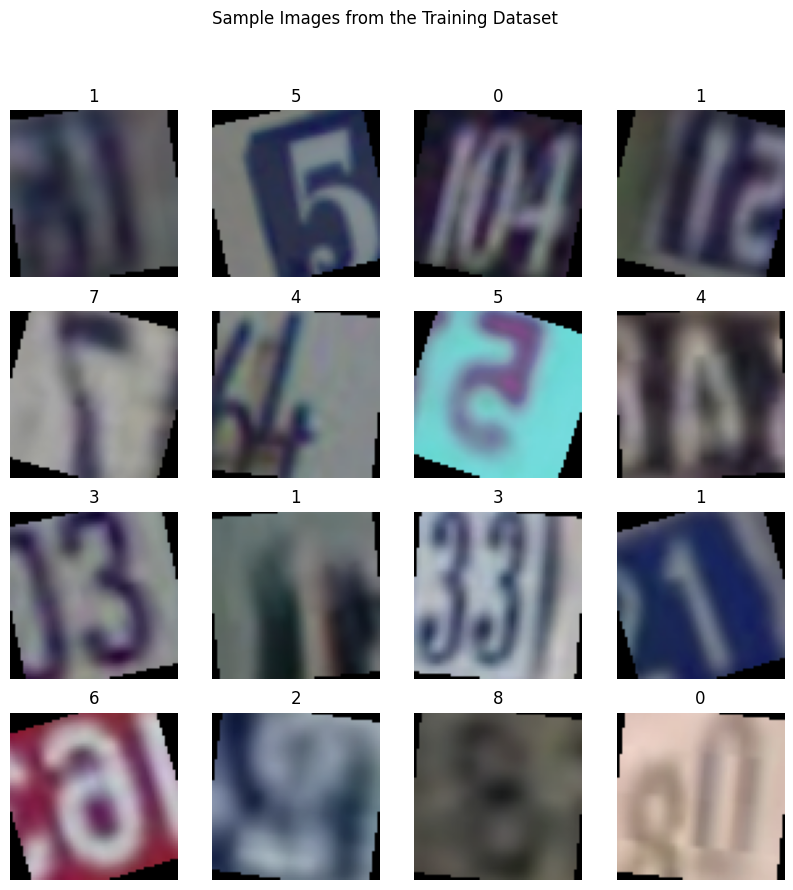

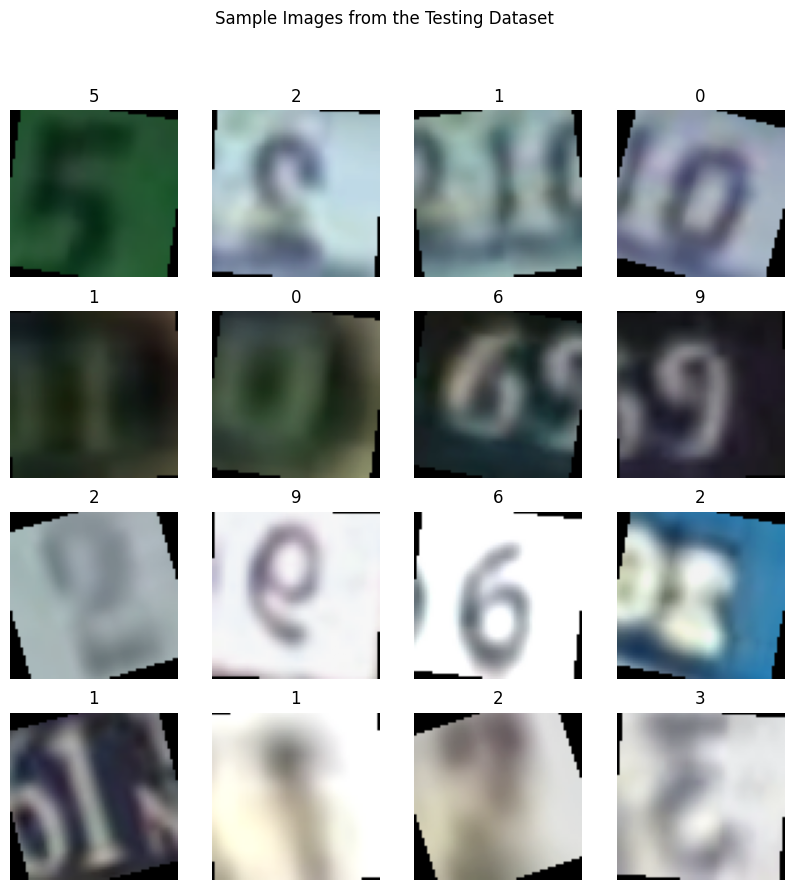

In [ ]:
class_labels = [
    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9'
]

fig, axs = plt.subplots(4, 4, figsize=(10,10))
fig.suptitle('Sample Images from the Training Dataset')
for i, (images, labels) in enumerate(train_loader):
    if i == 4:
        break
    for j in range(4):
        axs[i, j].imshow((images[j].permute(1,2,0)+1)/2)
        axs[i, j].set_title(class_labels[labels[j]])
        axs[i, j].axis('off')

# Display sample images
fig, axs = plt.subplots(4, 4, figsize=(10,10))
fig.suptitle('Sample Images from the Testing Dataset')
for i, (images, labels) in enumerate(test_loader):
    if i == 4:
        break
    for j in range(4):
        axs[i, j].imshow((images[j].permute(1,2,0)+1)/2)
        axs[i, j].set_title(class_labels[labels[j]])
        axs[i, j].axis('off')

plt.show()

In [ ]:

# Print the shape of the first training image
print(train_set[0][0].shape)

# Print the shape of the first testing image
print(test_set[0][0].shape)

torch.Size([3, 64, 64])
torch.Size([3, 64, 64])


In [ ]:
train_count = len(train_set)
test_count = len(test_set)

train_count,test_count

(73257, 26032)

## Step 2: Setting the AlexNet model for SVHH DATASET

In [ ]:

class AlexNet(nn.Module):
    def __init__(self, num_classes):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [ ]:
#checking for device
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Step 3 : Data Augmentation techniques

In [ ]:
transform  = transforms.Compose([
    transforms.Resize(72),
    transforms.RandomCrop(64),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(20, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

dataset = torchvision.datasets.SVHN(root='./data', split='train', download=True, transform=transformer)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

def multiply(data):
    return data * 2

augmented_data = []
for data, target in dataloader:
    augmented_data.append((multiply(data), target))

new_dataset = torch.utils.data.ConcatDataset([dataset, augmented_data])
train_set = torch.utils.data.ConcatDataset([dataset, augmented_data])


augmented_dataloader = train_loader = torch.utils.data.DataLoader(new_dataset, batch_size=64)

Using downloaded and verified file: ./data/train_32x32.mat


## Step 3 : Train the network and evaluate the performance on the testing data

In [ ]:
criterion = nn.CrossEntropyLoss

loss_function=nn.CrossEntropyLoss()

In [ ]:
from torch.optim import Adam
model=AlexNet(num_classes=10).to(device)

optimizer=Adam(model.parameters(),lr=0.0001,weight_decay=0.0001)

In [ ]:
from torch.autograd import Variable

In [ ]:
#Model training
num_epochs = 10
best_accuracy=0.0

for epoch in range(num_epochs):
    
    #Evaluation and training on training dataset
    model.train()
    train_accuracy=0.0
    train_loss=0.0
    
    for i, (images,labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        optimizer.zero_grad()
        
        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()
        
        
        train_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        
        train_accuracy+=int(torch.sum(prediction==labels.data))
        
    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count
    
    
    # Evaluation on testing dataset
    model.eval()
    
    test_accuracy=0.0
    for i, (images,labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        outputs=model(images)
        _,prediction=torch.max(outputs.data,1)
        test_accuracy+=int(torch.sum(prediction==labels.data))
    
    test_accuracy=test_accuracy/test_count
    
    
    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))
    
    #Save the best model
    if test_accuracy>best_accuracy:
        torch.save(model.state_dict(),'best_checkpoint.model')
        best_accuracy=test_accuracy

Epoch: 0 Train Loss: tensor(1.5809) Train Accuracy: 0.4344294743164476 Test Accuracy: 0.6498924400737554
Epoch: 1 Train Loss: tensor(0.8724) Train Accuracy: 0.7060485687374586 Test Accuracy: 0.7549938537185003
Epoch: 2 Train Loss: tensor(0.6926) Train Accuracy: 0.7759395006620528 Test Accuracy: 0.7860325752919484
Epoch: 3 Train Loss: tensor(0.6048) Train Accuracy: 0.8058752064649112 Test Accuracy: 0.8136524277811924
Epoch: 4 Train Loss: tensor(0.5527) Train Accuracy: 0.8225835073781345 Test Accuracy: 0.8234096496619545
Epoch: 5 Train Loss: tensor(0.5178) Train Accuracy: 0.8360020202847509 Test Accuracy: 0.8446911493546404
Epoch: 6 Train Loss: tensor(0.4885) Train Accuracy: 0.8462399497658927 Test Accuracy: 0.8526429010448678
Epoch: 7 Train Loss: tensor(0.4663) Train Accuracy: 0.8524646108904268 Test Accuracy: 0.8552166564228642
Epoch: 8 Train Loss: tensor(0.4464) Train Accuracy: 0.8603136901593021 Test Accuracy: 0.8627842655193608
Epoch: 9 Train Loss: tensor(0.4243) Train Accuracy: 0.8

In [ ]:
#Model training and saving best model
num_epochs = 15

for epoch in range(num_epochs):
    
    #Evaluation and training on training dataset
    model.train()
    train_accuracy=0.0
    train_loss=0.0
    
    for i, (images,labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        optimizer.zero_grad()
        
        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()
        
        
        train_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        
        train_accuracy+=int(torch.sum(prediction==labels.data))
        
    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count
    
    
    # Evaluation on testing dataset
    model.eval()
    
    test_accuracy=0.0
    for i, (images,labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        outputs=model(images)
        _,prediction=torch.max(outputs.data,1)
        test_accuracy+=int(torch.sum(prediction==labels.data))
    
    test_accuracy=test_accuracy/test_count
    
    
    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))
    
    #Save the best model
    if test_accuracy>best_accuracy:
        torch.save(model.state_dict(),'best_checkpoint.model')
        best_accuracy=test_accuracy

Epoch: 0 Train Loss: tensor(0.4146) Train Accuracy: 0.8706471736489346 Test Accuracy: 0.8720805162876459
Epoch: 1 Train Loss: tensor(0.4033) Train Accuracy: 0.8743191776895041 Test Accuracy: 0.8779578979717271
Epoch: 2 Train Loss: tensor(0.3908) Train Accuracy: 0.8778273748583753 Test Accuracy: 0.8796865396435156
Epoch: 3 Train Loss: tensor(0.3796) Train Accuracy: 0.8816904869159261 Test Accuracy: 0.884181007990166
Epoch: 4 Train Loss: tensor(0.3733) Train Accuracy: 0.8840383854102679 Test Accuracy: 0.8853334357713584
Epoch: 5 Train Loss: tensor(0.3647) Train Accuracy: 0.8876830883055544 Test Accuracy: 0.8871773202212662
Epoch: 6 Train Loss: tensor(0.3562) Train Accuracy: 0.8905087568423495 Test Accuracy: 0.8880608481868469
Epoch: 7 Train Loss: tensor(0.3494) Train Accuracy: 0.8913004900555578 Test Accuracy: 0.8926321450522434
Epoch: 8 Train Loss: tensor(0.3411) Train Accuracy: 0.8948905906602782 Test Accuracy: 0.8942071296865396
Epoch: 9 Train Loss: tensor(0.3352) Train Accuracy: 0.89

In [ ]:
#Model training and saving best model
num_epochs = 15

for epoch in range(num_epochs):
    
    #Evaluation and training on training dataset
    model.train()
    train_accuracy=0.0
    train_loss=0.0
    
    for i, (images,labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        optimizer.zero_grad()
        
        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()
        
        
        train_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        
        train_accuracy+=int(torch.sum(prediction==labels.data))
        
    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count
    
    
    # Evaluation on testing dataset
    model.eval()
    
    test_accuracy=0.0
    for i, (images,labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        outputs=model(images)
        _,prediction=torch.max(outputs.data,1)
        test_accuracy+=int(torch.sum(prediction==labels.data))
    
    test_accuracy=test_accuracy/test_count
    
    
    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))
    
    #Save the best model
    if test_accuracy>best_accuracy:
        torch.save(model.state_dict(),'best_checkpoint.model')
        best_accuracy=test_accuracy

Epoch: 0 Train Loss: tensor(0.3037) Train Accuracy: 0.9072307083282144 Test Accuracy: 0.8942839582052858
Epoch: 1 Train Loss: tensor(0.2977) Train Accuracy: 0.9093738482329333 Test Accuracy: 0.8991241548862938
Epoch: 2 Train Loss: tensor(0.2922) Train Accuracy: 0.9096605102584053 Test Accuracy: 0.8962430854333129
Epoch: 3 Train Loss: tensor(0.2892) Train Accuracy: 0.9120766616159548 Test Accuracy: 0.9029271665642287
Epoch: 4 Train Loss: tensor(0.2852) Train Accuracy: 0.9131141051367104 Test Accuracy: 0.9016979102642901
Epoch: 5 Train Loss: tensor(0.2826) Train Accuracy: 0.9132779120084088 Test Accuracy: 0.903119237861094
Epoch: 6 Train Loss: tensor(0.2786) Train Accuracy: 0.9153801001952032 Test Accuracy: 0.9018515673017824
Epoch: 7 Train Loss: tensor(0.2740) Train Accuracy: 0.9163492908527513 Test Accuracy: 0.8985479409956976
Epoch: 8 Train Loss: tensor(0.2709) Train Accuracy: 0.9171819757838842 Test Accuracy: 0.9030808236017209
Epoch: 9 Train Loss: tensor(0.2688) Train Accuracy: 0.91

In [ ]:
#Model training and saving best model
num_epochs = 15

for epoch in range(num_epochs):
    
    #Evaluation and training on training dataset
    model.train()
    train_accuracy=0.0
    train_loss=0.0
    
    for i, (images,labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        optimizer.zero_grad()
        
        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()
        
        
        train_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        
        train_accuracy+=int(torch.sum(prediction==labels.data))
        
    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count
    
    
    # Evaluation on testing dataset
    model.eval()
    
    test_accuracy=0.0
    for i, (images,labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        outputs=model(images)
        _,prediction=torch.max(outputs.data,1)
        test_accuracy+=int(torch.sum(prediction==labels.data))
    
    test_accuracy=test_accuracy/test_count
    
    
    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))
    
    #Save the best model
    if test_accuracy>best_accuracy:
        torch.save(model.state_dict(),'best_checkpoint.model')
        best_accuracy=test_accuracy

Epoch: 0 Train Loss: tensor(0.2505) Train Accuracy: 0.9233656851904938 Test Accuracy: 0.9103027043638598
Epoch: 1 Train Loss: tensor(0.2475) Train Accuracy: 0.9241437678310606 Test Accuracy: 0.910379532882606
Epoch: 2 Train Loss: tensor(0.2425) Train Accuracy: 0.9250856573433256 Test Accuracy: 0.9097264904732637
Epoch: 3 Train Loss: tensor(0.2442) Train Accuracy: 0.9249901033348349 Test Accuracy: 0.9084204056545789
Epoch: 4 Train Loss: tensor(0.2402) Train Accuracy: 0.9263551605989871 Test Accuracy: 0.9085740626920713
Epoch: 5 Train Loss: tensor(0.2355) Train Accuracy: 0.9273789535471013 Test Accuracy: 0.9101106330669945
Epoch: 6 Train Loss: tensor(0.2378) Train Accuracy: 0.9271741949574784 Test Accuracy: 0.910840503995083
Epoch: 7 Train Loss: tensor(0.2307) Train Accuracy: 0.9286757579480459 Test Accuracy: 0.9119161032575291
Epoch: 8 Train Loss: tensor(0.2321) Train Accuracy: 0.9291535279904992 Test Accuracy: 0.9145666871542717
Epoch: 9 Train Loss: tensor(0.2275) Train Accuracy: 0.930

In [ ]:
best_model = AlexNet(num_classes=10).to(device)
best_model.load_state_dict(torch.load('best_checkpoint_for_part4.model'))

<All keys matched successfully>

## Evaluating model's performance

In [ ]:
best_model.eval()
    
test_accuracy=0.0
for i, (images,labels) in enumerate(test_loader):
    if torch.cuda.is_available():
        images=Variable(images.cuda())
        labels=Variable(labels.cuda())
            
    outputs=best_model(images)
    _,prediction=torch.max(outputs.data,1)
    test_accuracy+=int(torch.sum(prediction==labels.data))
    
test_accuracy=test_accuracy/test_count

In [ ]:
print(' Test Accuracy: '+str(test_accuracy))

 Test Accuracy: 0.940681929932391
